In [1]:
save = '/home/561/mv7494/ENSOAnt_figures/'

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from dask.distributed import Client
from matplotlib import ticker
import cosima_cookbook as cc
import cf_xarray as cfxr
from matplotlib import gridspec
# import pint_xarray
from pint import application_registry as ureg
import cf_xarray.units
import matplotlib.pyplot as plt
import logging
import cmocean as cm
from wrf import to_np # conversion to arrays required for arrows on maps    
import string # for subplot annotation
import gsw # Gibbs Sea Water toolbox in python
import matplotlib.patheffects as PathEffects # to add white border around text in figure

session = cc.database.create_session() # default COSIMA data base
client = Client(n_workers=16)        
client
rotblau = [[0.4 , 0.  , 0.12], [0.47, 0.02, 0.13], [0.62, 0.07, 0.16], [0.66, 0.16, 0.2],
           [0.8 , 0.3 , 0.27], [0.87, 0.44, 0.35], [0.93, 0.58, 0.45], [0.96, 0.7 , 0.58], 
           [0.98, 0.8 , 0.71], [0.98, 0.94, 0.92], [0.93, 0.95, 0.96], [0.85, 0.91, 0.95],
           [0.76, 0.87, 0.93], [0.64, 0.8 , 0.89], [0.49, 0.72, 0.84], [0.34, 0.62, 0.79], 
           [0.23, 0.53, 0.74], [0.16, 0.44, 0.7] , [0.1 ,0.35, 0.6], [0.05, 0.24, 0.45], [0.02, 0.19, 0.38]]

### Getting the 1000 m isobath shelf mask

CPU times: user 3.08 s, sys: 1.38 s, total: 4.46 s
Wall time: 9.5 s


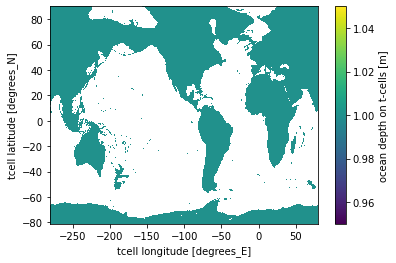

In [2]:
%%time
# first get the shelf mask
base_spin = '/g/data/ik11/outputs/access-om2-01/01deg_jra55v13_ryf9091/output979'
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').ht
above1000 = field.where(field >= 1000,1) # set all values smaller than 1000 to 1
above1000_tcells = above1000.where(above1000 < 1000, drop=True) # remove all values bigger than 1000

# now also for velocity cells
field = xr.open_mfdataset(base_spin + '/ocean/ocean_grid.nc').hu; above1000 = field.where(field >= 1000,1); above1000_ucells = above1000.where(above1000 < 1000, drop=False) 
above1000_tcells.plot()
# Wall time: 40.7 s

CPU times: user 1.37 s, sys: 196 ms, total: 1.57 s
Wall time: 4.67 s


Text(0.5, 1.0, 'Overturning streamfunction in the control simulation')

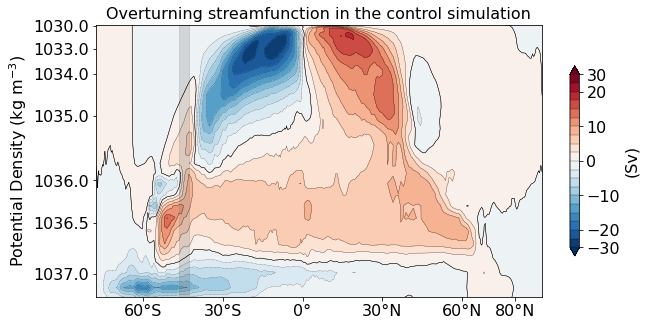

In [3]:
%%time
base = '/g/data/e14/mv7494/access-om2/archive/'
psi = xr.open_mfdataset(base+'1deg_jra55_rdf_branch2000_Control_PI_Offset/output*/ocean/ocean.nc').ty_trans_rho.sum('grid_xt_ocean').sel(time = slice('1972-01','2017-12')) 
psiGM = xr.open_mfdataset(base+'1deg_jra55_rdf_branch2000_Control_PI_Offset/output*/ocean/ocean.nc').ty_trans_rho_gm.sum('grid_xt_ocean').sel(time = slice('1972-01','2017-12')) 

# convert from kg m**-1 to Sv
rho = 1025 # mean density of sea-water in kg/m^3
psi = psi / (1e6*rho) # converts kg/s to Sv
psiGM = psiGM / (1e6*rho)


# Now, cumulatively sum the transport in the vertical. Note that in MOM5 the ty_trans_rho_GM variable is 
# computed differently and does not require summing in the vertical. Once the calculation has been laid out, 
# we then load the variable to force the computation to occur.
psi_avg = psi.cumsum('potrho').mean('time') - psi.sum('potrho').mean('time')
psi_avg = psi_avg + psiGM.mean('time')
psi_avg.load()


# ---------------------------------------------------------------------------------------------------------- #
# Plotting routine
# ---------------------------------------------------------------------------------------------------------- #

fig,ax1 = plt.subplots(1,1,figsize=(10, 5))
ticks = np.linspace(-25,25,21)
yticks = np.array([1030, 1033, 1034, 1035, 1036,1036.5, 1037])
plot_range = [-80, 80]

scfac = 4  ## A power to set the stretching
p1=ax1.contourf(psi_avg.grid_yu_ocean,(psi_avg.potrho-1028)**scfac, psi_avg, cmap='RdBu_r', levels=ticks, extend='both')

# add colour bar
#cax = fig.add_axes([0.075, -.01, 0.25, 0.015]) # position: [x0, y0, width, height]
cb=plt.colorbar(p1,orientation='vertical', shrink = 0.7)
cb.set_label(label='(Sv)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=5)
cb.locator = tick_locator;cb.update_ticks()  

p11a = ax1.contour(psi_avg.grid_yu_ocean,(psi_avg.potrho-1028)**scfac, psi_avg, levels=ticks, colors='k', linewidths=0.25)
p11 = ax1.contour(psi_avg.grid_yu_ocean,(psi_avg.potrho-1028)**scfac, psi_avg, levels=[0.0,], colors='k', linewidths=0.5)
cb.add_lines(p11a) # add contours to colour bar
#cb.add_lines(p11) 

ax1.set_yticks((yticks-1028)**scfac)
ax1.set_yticklabels(yticks)
ax1.set_ylim([0.5**scfac, 9.2**scfac])

# ticklabel  size
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
ax1.yaxis.offsetText.set_fontsize(16); ax1.yaxis.major.formatter._useMathText = True # use scientific notation
ax1.xaxis.offsetText.set_fontsize(16) # change font size of exponent

ax1.invert_yaxis()
ax1.set_ylabel('Potential Density (kg m$^{-3}$)', fontsize=16);


ax1.set_xticks([-80,-60,-30,0,30,60,80])
ax1.set_xticklabels(['80°S','60°S','30°S','0°','30°N','60°N','80°N'], minor=False)

# shade tapering zones at 30°S-25°S and 25°N-30°N 
# ax1.axvspan(-33.5-3.96,-33.5, color=rotblau[3], alpha=.5); #ax1.axvspan(40,45, color='grey', alpha=.25)
ax1.axvspan(-42.5-3.96,-42.5, color='grey', alpha=.25); #ax1.axvspan(40,45, color='grey', alpha=.25)

ax1.set_title('Overturning streamfunction in the control simulation', fontsize=16)
# Wall time: 3.8 s

### Load in EN and LN temperature and velocity anomalies

In [4]:
%%time
base   = ['/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/', '/g/data/e14/mv7494/access-om2/archive/']
exp    = ['01deg_jra55_ryf_Control','01deg_jra55_ryf_ENFull', '01deg_jra55_ryf_LNFull']
file   = ['ocean_month.nc', 'ocean_month.nc', 'ocean_month.nc']
region = ['Amundsen Sea', 'Bellingshausen Sea']
# ---------------------------------------------------------------------------------- #
depth     = [   0,   57]  # 97 m to 2488 m                                           #
sel_lat   = [   0,  500]  # 81.1°S - 59.5°S                                          #
sel_lon   = [1299, 2200]  # [1299, 2200] = 150°W - 60°W                              #
# ---------------------------------------------------------------------------------- #
for e in [1,2]: # loop through the two simulations ENFull and LNFull
    print(exp[e])
    if e == 1: last_output = 985; nr_outputs = 10 # for ENFull, I only have output976-output980
    if e == 2: last_output = 989; nr_outputs = 14

    a = [i for i in range(last_output+1-nr_outputs,last_output+1)] # create integer list
    s = list(range(0,nr_outputs))
    c = []; d = []; t = []; u = []; q = [] # empty list which I fill up; c for control, d for perturbation simulation
    for i in s: # loop through the number of files I would like
        # fill in empty list with integers trailing two zeros (000, 001, 002, ...)
        c.append(i); c[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[0] # string with all file locations
        d.append(i); d[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[e] 

        t.append(i); t[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/ocean_month.nc'
        u.append(i); u[i] = base[e] + exp[e]+'/output'+str(a[i]).zfill(3) + '/ocean/ocean_month.nc'

        q.append(i); q[i] = base[0] + exp[0]+'/output'+str(a[i]).zfill(3) + '/ocean/' + file[1]         
    average_DT = xr.open_mfdataset(q, decode_times = True).average_DT.mean('time').values.astype('int') / 1e9 # average time in seconds per month (the output is saved in ns, that's why /1e9) 

    temp_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).temp[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    temp        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).temp[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

    u_clim   = xr.open_mfdataset(c,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).u[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]
    u        = xr.open_mfdataset(d,combine='by_coords',chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'},decode_times = True).u[:, depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]]

    if e == 1: 
        temp_EN_anom_full_depth   = (temp   - temp_clim)
        u_EN_anom_full_depth      = (u   - u_clim)
        u_EN_full_depth           = u
    if e == 2: 
        temp_LN_anom_full_depth   = (temp   - temp_clim)
        u_LN_anom_full_depth      = (u   - u_clim)
        u_LN_full_depth           = u
print('----------------------------------')
# Wall time: 17.9 s

01deg_jra55_ryf_ENFull
01deg_jra55_ryf_LNFull
----------------------------------
CPU times: user 10.2 s, sys: 1.13 s, total: 11.4 s
Wall time: 13.8 s


### Load in RYF files

In [5]:
%%time
time_st = [407, 828] # select 1984-2019, same as Silvano et al. (2022), GRL
temp_clim = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='temp', session=session, frequency='1 monthly',
                                    attrs={'cell_methods': 'time: mean'},
                                    chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})[time_st[0]:time_st[1], depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean('time')
salt_clim = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='salt', session=session, frequency='1 monthly',
                                    attrs={'cell_methods': 'time: mean'},
                                    chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})[time_st[0]:time_st[1], depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean('time')
u_clim = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='u', session=session, frequency='1 monthly',
                                    attrs={'cell_methods': 'time: mean'},
                                    chunks = {'yu_ocean': '200MB', 'xu_ocean': '200MB'})[time_st[0]:time_st[1], depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean('time')
v_clim = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='v', session=session, frequency='1 monthly',
                                    attrs={'cell_methods': 'time: mean'},
                                    chunks = {'yu_ocean': '200MB', 'xu_ocean': '200MB'})[time_st[0]:time_st[1], depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean('time')
dzt = cc.querying.getvar(expt='01deg_jra55v13_ryf9091', variable='dzt', session=session, frequency='1 monthly',
                                    attrs={'cell_methods': 'time: mean'},
                                    chunks = {'yt_ocean': '200MB', 'xt_ocean': '200MB'})[time_st[0]:time_st[1], depth[0]:depth[1], sel_lat[0]:sel_lat[1], sel_lon[0]:sel_lon[1]].mean('time')

AS_map         = (temp_clim[38,120:262,250:491] - 273.15).load() #  468 m depth
u_map          = (u_clim[38,120:262,250:491]).load() #  468 m depth
v_map          = (v_clim[38,120:262,250:491]).load() #  468 m depth
AS_depth_temp  = (temp_clim[:,220:237,341] - 273.15).load()
AS_depth_dzt   = (dzt[:,220:237,341]).load()
AS_depth_salt  = (salt_clim[:,220:237,341]).load()
AS_depth_zonal = (u_clim[:,220:237,341]).load()

pres = gsw.p_from_z(-AS_depth_dzt, AS_depth_dzt.yt_ocean) # pressure in units of [dbar]
density = gsw.density.rho_t_exact(AS_depth_salt, AS_depth_temp, pres) - 1000 # density deviations from 1000 kg/m3

# Wall time: 3min 57s

CPU times: user 57.9 s, sys: 6.91 s, total: 1min 4s
Wall time: 2min 24s


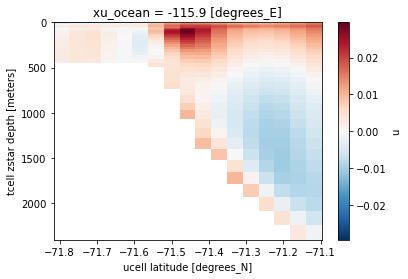

In [6]:
AS_depth_zonal.plot(yincrease=False)

### Import the Gibbs Seawater Toolbox to calculate the density surfaces
- gsw.p_from_z(z, lat)
- gsi.density.rho(SA, CT, p)

CPU times: user 8.43 s, sys: 1.58 s, total: 10 s
Wall time: 22 s


<Figure size 1440x576 with 0 Axes>

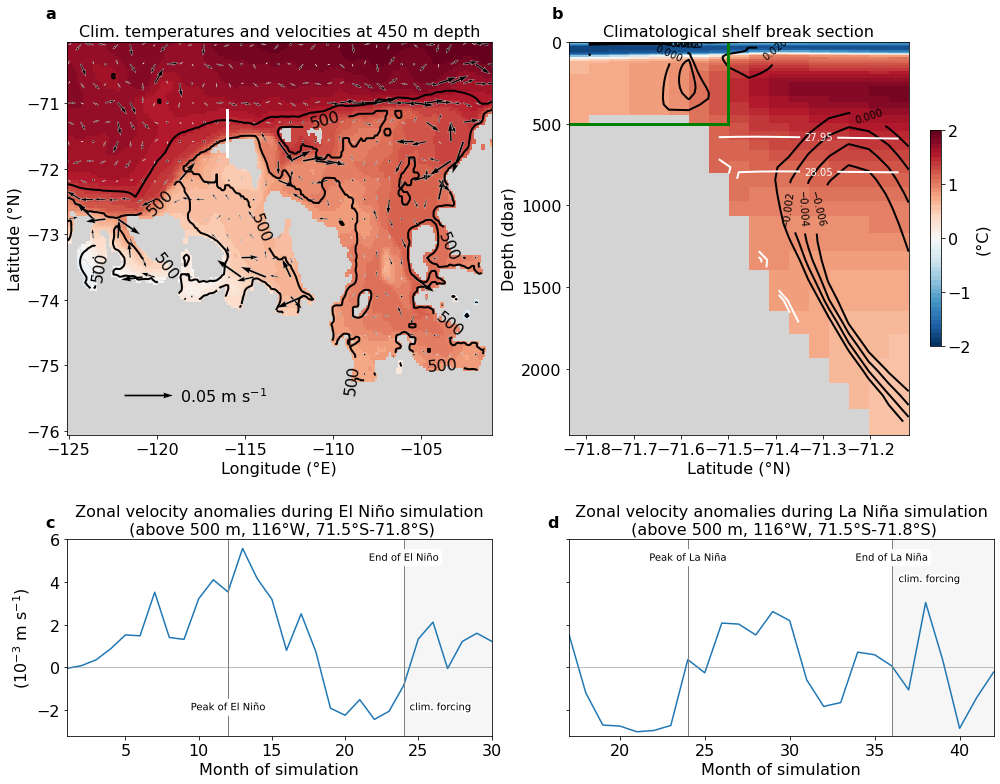

In [7]:
%%time
plt.figure(figsize=(20,8))
fig = plt.figure(figsize=(14, 11),tight_layout=True,facecolor='w',edgecolor='k')
gs = gridspec.GridSpec(2,2, height_ratios = [1,.5]) 

time_EN = np.linspace(1, len(u_EN_anom_full_depth), len(u_EN_anom_full_depth))
time_LN = np.linspace(1, len(u_LN_anom_full_depth), len(u_LN_anom_full_depth))

ax1 = plt.subplot(gs[0,0]); ax1.set_facecolor([.83, .83, .83])
# -------------------------------------------------------------------------------------------- #
p1   = AS_map.plot.pcolormesh(add_colorbar=False, levels=np.linspace(-2,2,50), cmap='RdBu_r')
p11  = AS_map.plot.contour(levels = [0], linewidths=.1, cmap='k')
p111 = field.plot.contour(levels = [500, 2000], linewidths=2, cmap='k') # 1000 m isobath
ax1.clabel(p111, [500, 2000], inline=True, fontsize=16)

plt.title('Clim. temperatures and velocities at 450 m depth', fontsize=16)
txt = plt.plot([-116,-116], [-71.8, -71.1], color = 'white', linewidth=3)
plt.ylabel('Latitude (°N)',fontsize=16); plt.xlabel('Longitude (°E)',fontsize=16)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)


# adding velocity arrows
X = u_map.xu_ocean; Y = u_map.yu_ocean
U = u_map; V = v_map
# widths = np.linspace(-.0001, .0001, X.size)
# Add the wind stress arrows, only plotting every 30th data point.
Q = plt.quiver(to_np(X[::7]),   to_np(Y[::7]), to_np(U[::7, ::7]), to_np(V[::7, ::7]), 
           scale=.4, minshaft = 2, scale_units='height', width=.005, linewidths=.3, edgecolor=('w')) 
                      # minshaft = select minimum sized arrow (i.e., only those larger than 2)
# reference key on the map
                    # x0,   y0, scale
qk = plt.quiverkey(Q, .25, .1, 0.05, r'0.05 m s$^{-1}$', labelpos='E', fontproperties={'size':16}) 

ax1.text(-.05, 1.06, string.ascii_lowercase[0], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

# -------------------------------------------------------------------------------------------- #
ax1 = plt.subplot(gs[0,1])

ax1.set_facecolor([.83, .83, .83])
p1   = AS_depth_temp.plot.pcolormesh(add_colorbar=False, levels=np.linspace(-2,2,50), cmap='RdBu_r')
p11  = AS_depth_zonal.plot.contour(levels=[-.006, -.004, -.002, 0, .02, .03, .04], linewidths=2, cmap='k')
p111  = density.plot.contour(levels=[28.05, 27.95], linewidths=2, cmap='white')

ax1.clabel(p11, [-.006, -.004, -.002, 0, .02, .03, .04], inline=True, fontsize=10) # contour labels
ax1.clabel(p111, [28.05, 27.95], inline=True, colors='white', fontsize=10)

plt.gca().invert_yaxis()
txt = plt.plot([-71.5,-71.5], [0, 500], color = 'green', linewidth=3); txt = plt.plot([-90,-71.5], [500, 500], color = 'green', linewidth=3)

cb = plt.colorbar(p1, shrink=.55, orientation='vertical'); 
cb.set_label(label='(°C)', size=16)
cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
cb.locator = tick_locator;cb.update_ticks() 

plt.title('Climatological shelf break section', fontsize=16)
plt.ylabel('Depth (dbar)',fontsize=16); plt.xlabel('Latitude (°N)',fontsize=16)
plt.xticks(fontsize=16); plt.yticks(fontsize=16)
ax1.text(-.05, 1.06, string.ascii_lowercase[1], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top

# -------------------------------------------------------------------------------------------- #
title_str = ['El Niño', 'La Niña']
for f in range(2):
    if f == 0:
        ax1 = plt.subplot(gs[1,0]);
        time = time_EN; data = u_EN_anom_full_depth[:,0:40,220:228,341].mean(['st_ocean', 'yu_ocean']) * 1e3 # to make a prettier y-axis, write this in ylabel
        x_limiten = [1, 30]
    if f == 1:
        ax1 = plt.subplot(gs[1,1]);
        time = time_LN; data = u_LN_anom_full_depth[:,0:40,220:228,341].mean(['st_ocean', 'yu_ocean']) * 1e3
        x_limiten = [17, 42]
        
    plt.plot(time, data) # upper 500 m, south of 71.5°S
    plt.title('\n Zonal velocity anomalies during '+title_str[f]+' simulation \n (above 500 m, 116°W, 71.5°S-71.8°S)', fontsize=16)
    # plt.axhline(0, linewidth=.5, c='grey')
    plt.ylabel('(10$^{-3}$ m s$^{-1}$)', fontsize=16)
    plt.xlim(x_limiten); plt.ylim([-3.2,6])
    plt.axhline(0, lw=.5, c='grey')
    ax1.text(-.05, 1.06, string.ascii_lowercase[f+2], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    plt.xticks(fontsize=16); plt.yticks(fontsize=16);
    plt.xlabel('Month of simulation', fontsize=16)
    if f == 1: ax1.set_yticklabels([]); plt.ylabel(None)
# -------------------------------------------------------------------------------------------- #

    if f == 0:
        plt.axvline(12, c='grey', linewidth=1); plt.axvline(24, c='grey', linewidth=1)
        ax1.text(12, -2, 'Peak of El Niño', fontsize=10, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(24, 5, 'End of El Niño', fontsize=10, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(24.4, -2, 'clim. forcing', fontsize=10, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        ax1.axvspan(24, 30, color=[.83, .83, .83], alpha=.2) # shade period where I applied climatological, RYF, forcing
    if f == 1:
        plt.axvline(24, c='grey', linewidth=1); plt.axvline(36, c='grey', linewidth=1)
        ax1.text(24, 5, 'Peak of La Niña', fontsize=10, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(36, 5, 'End of La Niña', fontsize=10, ha='center', rotation=0, c='k', bbox=dict(boxstyle="round", ec='w',fc='w')
                ).set_path_effects([PathEffects.withStroke(linewidth=3, foreground='w')])
        ax1.text(36.4, 4, 'clim. forcing', fontsize=10, ha='left').set_path_effects([PathEffects.withStroke(linewidth=4, foreground='w')])
        ax1.axvspan(36, 42, color=[.83, .83, .83], alpha=.2) # shade period where I applied climatological, RYF, forcing

        # ax1 = plt.subplot(gs[1,1]); ax1.text(-.05, 1.06, string.ascii_lowercase[3], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
# plt.plot(time_LN, u_LN_full_depth[:,0:40,220:228,341].max(['st_ocean', 'yu_ocean'])) # upper 500 m, south of 71.5°S
# plt.title('Maximum zonal velocity during La Niña \n (upper 500 m, south of 71.5°S)', fontsize=16)
# # plt.axhline(0, linewidth=.5, c='grey')
# 
# plt.xlim([17, 42]); plt.ylim([0,.06])


# --- saving as 300 dpi .PNG image in specified folder ------------------------------------------------------ #
plt.savefig(save + 'checking_Amundsen_Sea_Undercurrent_for_reviews', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,                                           #
            format=None, transparent=False, bbox_inches='tight',                                              #
            pad_inches=0.1, metadata=None)                                                                    #
# --- end of script ----------------------------------------------------------------------------------------- # 
# Wall time: 8.22

### more panels to check strength of the slope/undercurrent

CPU times: user 13.9 s, sys: 2.56 s, total: 16.4 s
Wall time: 1min 2s


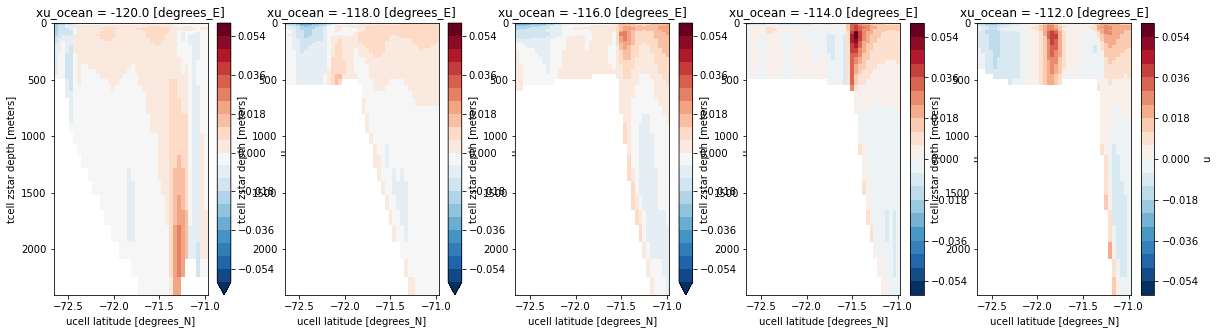

In [8]:
%%time 
plt.figure(figsize=(20,5))
plt.subplot(1,5,1); (u_clim[:,200:240,300]).plot(yincrease=False, levels=np.linspace(-.06,.06,21)) # 120°W
plt.subplot(1,5,2); (u_clim[:,200:240,320]).plot(yincrease=False, levels=np.linspace(-.06,.06,21)) # 118°W
plt.subplot(1,5,3); (u_clim[:,200:240,340]).plot(yincrease=False, levels=np.linspace(-.06,.06,21)) # 116°W
plt.subplot(1,5,4); (u_clim[:,200:240,360]).plot(yincrease=False, levels=np.linspace(-.06,.06,21)) # 114°W
plt.subplot(1,5,5); (u_clim[:,200:240,380]).plot(yincrease=False, levels=np.linspace(-.06,.06,21)) # 112°W
# --- saving as 300 dpi .PNG image in specified folder ------------------------------------------------------ #
plt.savefig(save + 'zonal_velocities_across_the_shelf', dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,                                           #
            format=None, transparent=False, bbox_inches='tight',                                              #
            pad_inches=0.1, metadata=None)                                                                    #
# --- end of script ----------------------------------------------------------------------------------------- # 
# Wall time: 1min 5s

### Load in the data for fancy plotting

In [9]:
%%time
experiment = 'EN' # 'LN' # 'Control'
u_clim1 = u_EN_anom_full_depth[11,:,200:240,300].load()#; u_clim[:,200:240,300].load()
u_clim2 = u_EN_anom_full_depth[11,:,200:240,320].load()#;u_clim[:,200:240,320].load()
u_clim3 = u_EN_anom_full_depth[11,:,200:240,340].load()#;u_clim[:,200:240,340].load()
u_clim4 = u_EN_anom_full_depth[11,:,200:240,360].load()#;u_clim[:,200:240,360].load()
u_clim5 = u_EN_anom_full_depth[11,:,200:240,380].load()#;u_clim[:,200:240,380].load()
# Wall time: 1min 2s

CPU times: user 2 s, sys: 514 ms, total: 2.52 s
Wall time: 16.7 s


CPU times: user 1.31 s, sys: 123 ms, total: 1.44 s
Wall time: 1.27 s


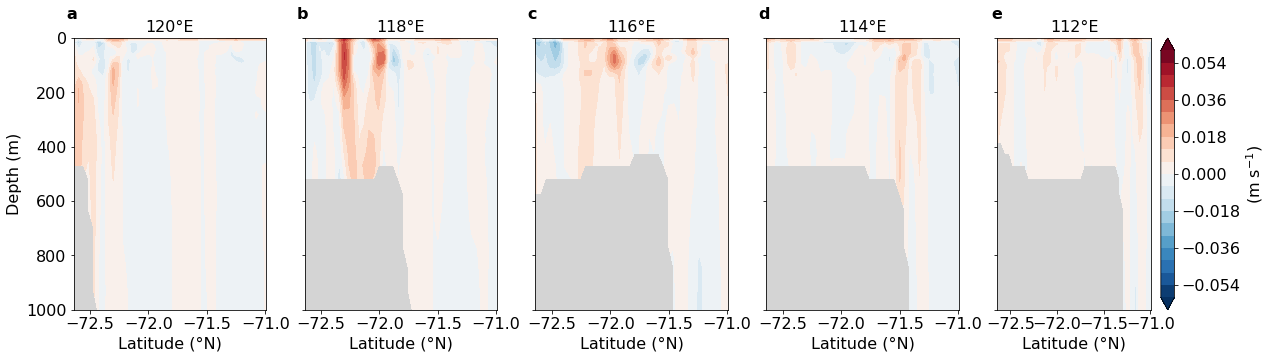

In [10]:
%%time 
ticks = np.linspace(-.06,.06,21) # extent of colour bar
suffix = ['120°E', '118°E', '116°E', '114°E', '112°E']
plt.figure(figsize=(20,5))
for f in range(5):
    if f == 0: data = u_clim1
    if f == 1: data = u_clim2
    if f == 2: data = u_clim3
    if f == 3: data = u_clim4
    if f == 4: data = u_clim5
        
    ax1 = plt.subplot(1,5,f+1)   
    ax1.set_facecolor([.83, .83, .83])
    # [1023, 1024, 1025, 1027, 1027.5, 1027.6, 1027.7, 1027.77, 1027.88, 1028]
    # ----------------------------------------------------------------------------------------------------------------------------------------- #
    p1 = plt.contourf(u_clim1.yu_ocean, u_clim1.st_ocean, data, cmap = 'RdBu_r', levels=ticks, extend='both', colorbar=True)
    # p11 = plt.contour(u_clim1.yu_ocean, u_clim1.st_ocean, data, colors = 'grey', levels=[0], linewidth=.1)
    

    ax1.text(-.04, 1.07 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    plt.gca().invert_yaxis() # invert x axis
    plt.ylabel('Depth (m)', fontsize=16); plt.xlabel('Latitude (°N)', fontsize=16);
    plt.title(suffix[f], fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.ylim([1000,0])
    if f == 4: 
        cb = plt.colorbar()
        cb_txt = cb.set_label(label='(m s$^{-1}$)', size=16); cb.ax.tick_params(labelsize=16); tick_locator = ticker.MaxNLocator(nbins=4)
    if f >=1: ax1.set_yticklabels([]); plt.ylabel(None) # suppress superfluous labels
# --- saving as 300 dpi .PNG image in specified folder ------------------------------------------------------ #
plt.savefig(save + 'zonal_velocities_across_the_shelf_fancy_'+experiment, dpi=300, facecolor='w',             #
            edgecolor='w', orientation='landscape', papertype=None,                                           #
            format=None, transparent=False, bbox_inches='tight',                                              #
            pad_inches=0.1, metadata=None)                                                                    #
# --- end of script ----------------------------------------------------------------------------------------- # 
# Wall time: 1min 5s

I think the above is all consistent with what you've said, except:
"Because we have less Ekman transport at the surface and a stronger undercurrent at depth, we have a baroclinic response overall?" -> I don't think so. You'd need to plot the vertical structure of the velocity anomalies to see if the response is baroclinic or not, and you haven't done this.



### Plotting the vertical structure of the velocity anomalies 

CPU times: user 3.87 s, sys: 700 ms, total: 4.57 s
Wall time: 20 s


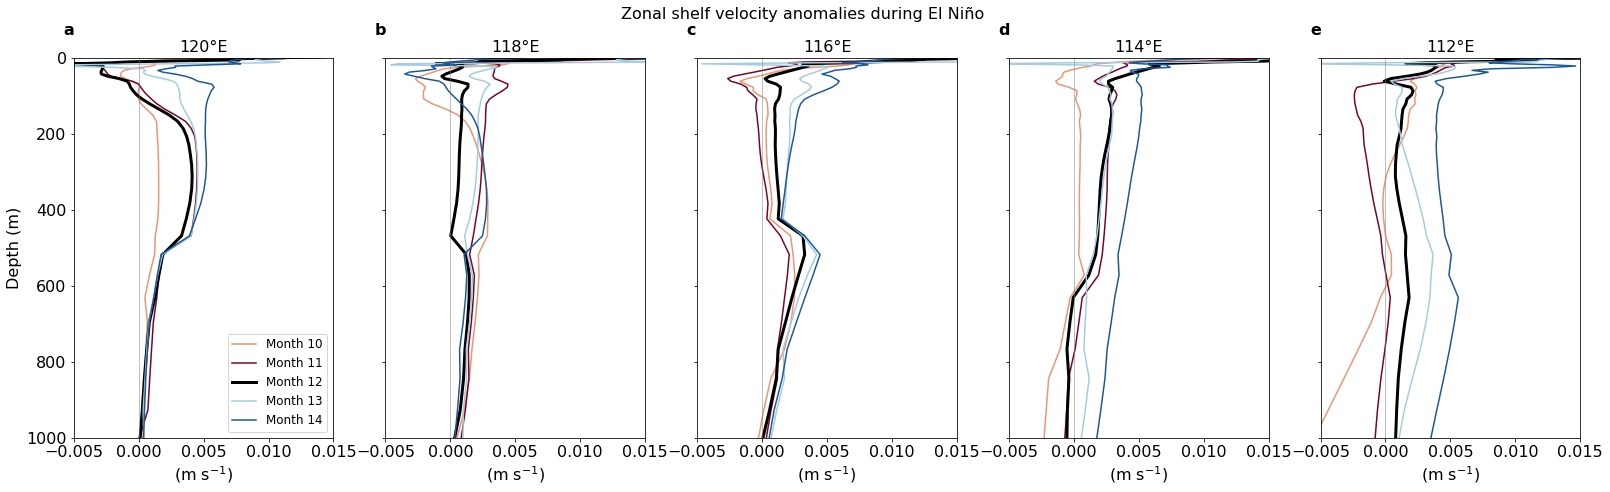

In [11]:
%%time
rotblau_r = [

    [0.93, 0.58, 0.45],
    [0.47, 0.02, 0.13],
    [   0,    0,    0],
    [0.64, 0.8 , 0.89],
    [ 0.1, 0.35,  0.6]]

suffix = ['120°E', '118°E', '116°E', '114°E', '112°E']
event = ['El Niño']
monate = [10,15]
cmap = rotblau_r#; plt.get_cmap('jet')
plt.figure(figsize=(27,7))

# ----------------------------------------------------------------------------------------------------------------------- #
for f in range(5):
    if f == 0: data = (u_EN_anom_full_depth)[monate[0]:monate[1],:,200:215,300].mean('yu_ocean').load() # [monate[0]:monate[1],:,200:240,300]
    if f == 1: data = (u_EN_anom_full_depth)[monate[0]:monate[1],:,215:225,320].mean('yu_ocean').load()
    if f == 2: data = (u_EN_anom_full_depth)[monate[0]:monate[1],:,220:230,340].mean('yu_ocean').load()
    if f == 3: data = (u_EN_anom_full_depth)[monate[0]:monate[1],:,225:235,360].mean('yu_ocean').load()
    if f == 4: data = (u_EN_anom_full_depth)[monate[0]:monate[1],:,230:235,380].mean('yu_ocean').load()

    ax1 = plt.subplot(1,5,f+1)
    for s in range(len(data.time)):
        # color = cmap(float(s)/(monate[1]-monate[0]))
        lw = 1.5
        if s == len(data.time) / 2 - .5: lw = 3
        plt.plot(data[s,:], data.st_ocean, color = rotblau_r[s], label = 'Month '+ str(monate[0]+s), lw=lw)
    if f == 0: plt.legend(fontsize=12)
# ----------------------------------------------------------------------------------------------------------------------- #
    plt.axvline(0, c='grey', lw=.5)
    ax1.text(-.04, 1.06 ,string.ascii_lowercase[f], transform=ax1.transAxes, size=16, weight='bold') # bold letter a at the top
    plt.gca().invert_yaxis() # invert x axis
    if f == 0: plt.ylabel('Depth (m)', fontsize=16)
    plt.xlabel('(m s$^{-1}$)', fontsize=16);
    plt.title(suffix[f], fontsize=16)
    plt.xticks(fontsize=16); plt.yticks(fontsize=16)
    plt.ylim([1000,0])     # y-limit
    plt.xlim([-.005, .015]); plt.locator_params(axis='x', nbins=5) # x-limit & number of x ticks
    if f in [1,2,3,4,5]: ax1.set_yticklabels([])
              
plt.suptitle('Zonal shelf velocity anomalies during ' + event[0], fontsize=16)
# --- saving as 300 dpi .PNG image in specified folder ------------------------------------------------------- #
plt.savefig(save + 'zonal_velocity_anomalies_across_the_AS_shelf_with_time_'+event[0], dpi=300, facecolor='w', #
            edgecolor='w', orientation='landscape', papertype=None,                                            #
            format=None, transparent=False, bbox_inches='tight',                                               #
            pad_inches=0.1, metadata=None)                                                                     #
# --- end of script ------------------------------------------------------------------------------------------ # 
# Wall time: 20.1 s

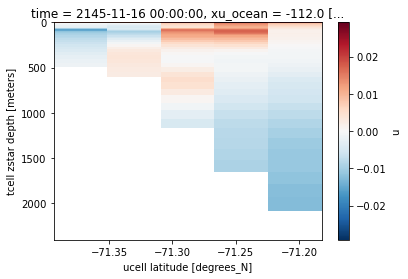

In [12]:
(u_EN_anom_full_depth)[monate[0],:,230:235,380].plot(yincrease=False)

In [13]:
# ----------------------------------------------------------------------------------------------------------------------- #
#                                                   Notes down below                                                      #
# ----------------------------------------------------------------------------------------------------------------------- #